# Exercise 1: Optimize lepton selection

* First, print the distributions of the relevant variables for *all* the Monte Carlo samples (i.e. all the *channels* of the $Z$-boson decay to be studied). Which variables are these? Give sensible ranges to include all the events in the samples (both MC and OPAL data) 
* Do the same for **one** of the OPAL data samples (your lab assistant will decide which one you choose).
* Describe the results.
* Optimize the object selection by applying cuts. Make a strategy on how to proceed to find the optimal selection. which information do you need?
* Determine the efficiency and the amount of background for each $Z$ decay channel. Use the simulated events $e^+e^-$, $\mu^+\mu^-$, $\tau^+\tau^-$ and hadrons ($qq$). Represent the result in a matrix form and think carefully about how you have to correct the measured rates. Don't forget to calculate the errors!
* How do we estimate the statistical fluctuations per bin?

**Import libraries**:

In [2]:
import uproot
import awkward as ak
import mplhep
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

**Open Monte Carlo samples**

We will open data and Monte Carlo samples using **uproot**. Uproot is a reader and a writer of the ROOT file format using only Python and Numpy. Unlike PyROOT and root_numpy, uproot does not depend on C++ ROOT so that no local compilation of the ROOT libraries is needed to access the data.

You can find more info on uproot following the references:
* Github repo: https://github.com/scikit-hep/uproot4
* Tutorial: https://masonproffitt.github.io/uproot-tutorial/
* Video tutorial on uproot and awkward arrays:  https://www.youtube.com/embed/ea-zYLQBS4U 

First, let's specify the folder path for both data and Monte Carlo (MC) samples

In [3]:
# Read the Monte Carlo data
path_mc = 'opal_data/mc/'

# Open the files
file_mc_ee = uproot.open(path_mc+'ee.root')
file_mc_mm = uproot.open(path_mc+'mm.root')
file_mc_tt = uproot.open(path_mc+'tt.root')
file_mc_qq = uproot.open(path_mc+'qq.root')


# Name the ttree name
ttree_name = 'myTTree'

# Print list of 'branches' of the TTree (i.e. list of variable names)
variable_names = file_mc_ee[ttree_name].keys()

# Load branches
branches_ee = file_mc_ee[ttree_name].arrays()
branches_mm = file_mc_mm[ttree_name].arrays()
branches_tt = file_mc_tt[ttree_name].arrays()
branches_qq = file_mc_qq[ttree_name].arrays()
branches_tot = ak.concatenate((branches_ee, branches_mm, branches_tt, branches_qq))


# convert data into dictionaries of numpy arrays
array_ee = {}
array_mm = {}
array_tt = {}
array_qq = {}
array_tot = {}

for variable in variable_names:
    array_ee[variable] = ak.to_numpy(branches_ee[variable])
    array_mm[variable] = ak.to_numpy(branches_mm[variable])
    array_tt[variable] = ak.to_numpy(branches_tt[variable])
    array_qq[variable] = ak.to_numpy(branches_qq[variable])
    array_tot[variable] = ak.to_numpy(branches_tot[variable])

all_channels = ['tot', 'ee', 'mm', 'tt', 'qq']
dist_channels = ['ee', 'mm', 'tt', 'qq']
array = {'ee' : array_ee,
         'mm' : array_mm,
         'tt' : array_tt,
         'qq' : array_qq,
         'tot' : array_tot}


# print('These are the different variables: ', variable_names)
# print('E_lep = {0:4.2f} GeV = const.'.format(branches_ee['E_lep'][0]))

| Variable name | Description |
| --- | --- | 
| run| Run number |
| event | Event number |
| Ncharged | Number of charged tracks |
| Pcharged | Total scalar sum of track momenta |
| E_ecal| Total energy measured in the electromagnetic calorimeter |
| E_hcal | Total energy measured in the hadronic calorimeter |
| E_lep | LEP beam energy (=$\sqrt{s}/2$) |
| cos_thru | cosine of the polar angle between beam axis and thrust axis |
| cos_thet | cosine of the polar angle between incoming positron and outgoing positive particle |


For our statistical analysis the run and event number are not interesting. The beam energy $E_\mathrm{lep}=45.64\,\mathrm{GeV}$ is constant for the data set. The scattering angles will not be used for identifying the channels and are subsect of analysis further below. Therefore we first concentrate only on the subset of variables Ncharged, Pcharged, E_ecal and E_hcal.

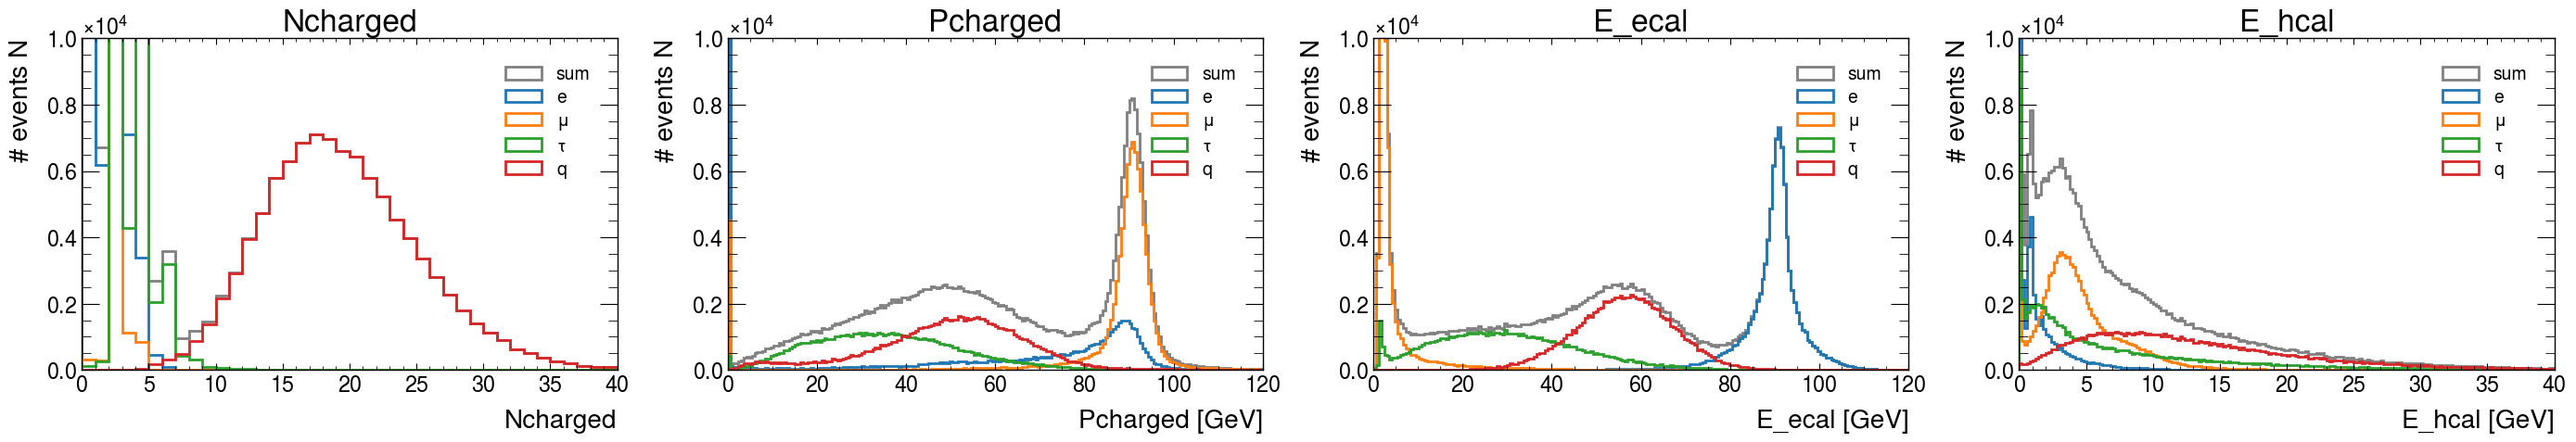

In [174]:
### We define set of variables of interest
### and corresponding dictionaries of plot settings, etc.
variables = ['Ncharged', 'Pcharged', 'E_ecal', 'E_hcal']

# units corresponding to the variables
unit = {'Ncharged' : '',
         'Pcharged' : ' [GeV]',
         'E_ecal' : ' [GeV]',
         'E_hcal' : ' [GeV]'}

# bins for histograms
bins_mc = {'Ncharged' : np.linspace(0, 40, 41),
           'Pcharged' : np.linspace(0, 120, 201),
           'E_ecal' : np.linspace(0, 120, 201),
           'E_hcal' : np.linspace(0, 40, 201)}

# limits for the plots
ylims_mc = {'Ncharged' : (0, 1e4),
            'Pcharged' : (0, 1e4),
            'E_ecal' : (0, 1e4),
            'E_hcal' : (0, 1e4)}


### Dictionaries concerning different channels
plot_label = {'ee' : r'$e$',
              'mm' : r'$\mu$',
              'tt' : r'$\tau$',
              'qq' : r'$q$',
              'tot' : 'sum'}

color = {'ee' : 'tab:blue',
         'mm' : 'tab:orange',
         'tt' : 'tab:green',
         'qq' : 'tab:red',
         'tot' : 'grey'}


### plotting
plt.style.use(mplhep.style.ATLAS)  # plot style of ATLAS
fig, axes = plt.subplots(1, 4, figsize=(28, 5))

# plot histograms for all variables and channels
for (i, variable) in zip(range(4), variables):
    for channel in all_channels:
        axes[i].hist(array[channel][variable],
                     bins=bins_mc[variable],
                     histtype='step',
                     linewidth=2,
                     color=color[channel],
                     label=plot_label[channel])


    # plot settings
    axes[i].set_ylim(ylims_mc[variable])
    axes[i].set_title(variable)
    axes[i].set_xlabel(variable + unit[variable])
    axes[i].set_ylabel(r'# events $N$')
    axes[i].legend()


plt.tight_layout()
plt.show()

In the histograms above we see different kind of distributions for different variables and decay channels. Some distributions closely resemble a Gaussian such that a cut can easily be defined via mean and standard deviation. If for example we choose an interval of 3$\sigma$ we keep approximately 99% of the events. Since the distributions partially overlap, this also causes many false positive events. We hope to make the filters unique by applying such cuts on multiple variables.

Other distributions are not easily approximated by a Guassian. These are e.g. the Ncharged curves for $e$, $\mu$ and $\tau$, since they have a small mean. Also Pcharged is problematic since often the momentum is missing in the data (is this interpretation correct?), e.g., for $e$ about 50% of the events have Pcharged=0, while the rest of the distribution is centred at higher values.


All these effects have to be considered to define meaningful cuts. Nevertheless, let us start the analysis by calculating the mean and standard deviation of all distributions.

In [5]:
# data structure for mean values
mean = {'ee' : {},
        'mm' : {},
        'tt' : {},
        'qq' : {}}

# data structure for standard deviation
std = {'ee' : {},
       'mm' : {},
       'tt' : {},
       'qq' : {}}

# auxillary data structure for masks and masked arrays
aux_mask = {'ee' : {},
            'mm' : {},
            'tt' : {},
            'qq' : {}}

aux_array = {'ee' : {},
             'mm' : {},
             'tt' : {},
             'qq' : {}}


# calculate values for all variables and channels
for var in variables:
    for ch in dist_channels:
        # aux array is copied from regular array
        aux_array[ch][var] = array[ch][var]

        # Pcharged exhibits unexpected behavior:
        # a significant number of values is 0.
        # there are few outliers with very high values distorting the statistics
        # therefore consider only 'regular' events to describe the distributions
        if var == 'Pcharged':
            # apply lower and upper cut
            aux_mask[ch][var] = (array[ch][var] > 0.)
            aux_mask[ch][var] *= (array[ch][var] < 120.)
            aux_array[ch][var] = aux_array[ch][var][aux_mask[ch][var]]

        # calculate statistics of possibly masked arrays
        mean[ch][var] = aux_array[ch][var].mean()
        std[ch][var] = aux_array[ch][var].std()


    # print as a table
    print(var)
    print('    mean  +-   std, [min,      max]')
    for ch in dist_channels:
        print('{0}: {1:5.2f} +- {2:5.2f}, [{3:5.2f}, {4:6.2f}]'.format(
                ch, mean[ch][var], std[ch][var],
                aux_array[ch][var].min(), aux_array[ch][var].max()))
    print('\n')

Ncharged
    mean  +-   std, [min,      max]
ee:  1.65 +-  1.07, [ 0.00,   9.00]
mm:  2.02 +-  0.26, [ 0.00,   6.00]
tt:  2.87 +-  1.30, [ 0.00,  18.00]
qq: 18.88 +-  5.74, [ 3.00,  48.00]


Pcharged
    mean  +-   std, [min,      max]
ee: 72.96 +- 21.67, [ 0.19, 119.97]
mm: 89.30 +-  8.20, [ 0.25, 119.99]
tt: 35.72 +- 16.28, [ 0.16, 119.95]
qq: 49.62 +- 17.19, [ 0.31, 120.00]


E_ecal
    mean  +-   std, [min,      max]
ee: 89.55 +-  6.84, [41.55, 124.32]
mm:  3.66 +-  5.36, [ 0.20,  87.72]
tt: 29.85 +- 16.07, [ 0.63, 101.03]
qq: 56.27 +- 10.80, [14.92, 107.53]


E_hcal
    mean  +-   std, [min,      max]
ee:  0.79 +-  1.89, [ 0.00,  82.45]
mm:  4.52 +-  3.49, [ 0.00,  98.78]
tt:  6.96 +-  8.24, [ 0.00, 110.91]
qq: 13.38 +-  9.24, [ 0.00,  95.67]




### Apply cuts

Apply cuts to the different distributions. Individual notes to the different cut selections are commented.
The general reference where to apply a cut is: mean +- 3 sigma, to include most of all events in our selection.
In cases of specific asymmetric distributions or something similar, a correction by eye is performed.

In [6]:
### define cuts
cuts = {'ee' : {},
        'mm' : {},
        'tt' : {},
        'qq' : {}}

cuts['ee'] = {'Ncharged' : (0, 6),
              'Pcharged' : (mean['ee']['Pcharged'] - 3*std['ee']['Pcharged'], 100),  # asymmetry of distr. 3σ left, 1-2σ right
              'E_ecal' : (mean['ee']['E_ecal'] - 3*std['ee']['E_ecal'],
                          mean['ee']['E_ecal'] + 3*std['ee']['E_ecal']),
              'E_hcal' : (0, mean['ee']['E_hcal'] + 3*std['ee']['E_hcal'])}

cuts['mm'] = {'Ncharged' : (0, 4),
              'Pcharged' : (mean['mm']['Pcharged'] - 3*std['mm']['Pcharged'],
                            mean['mm']['Pcharged'] + 3*std['mm']['Pcharged']),
              'E_ecal' : (0, mean['mm']['E_ecal'] + 3*std['mm']['E_ecal']),
              'E_hcal' : (0, mean['mm']['E_hcal'] + 3*std['mm']['E_hcal'])}

cuts['tt'] = {'Ncharged' : (0, 7),
              'Pcharged' : (mean['tt']['Pcharged'] - 2*std['tt']['Pcharged'],
                            mean['tt']['Pcharged'] + 3*std['tt']['Pcharged'] - 15),
              'E_ecal' : (0, mean['tt']['E_ecal'] + 3*std['tt']['E_ecal'] - 5),
              'E_hcal' : (0, mean['tt']['E_hcal'] + 3*std['tt']['E_hcal'])}

cuts['qq'] = {'Ncharged' : (7, 39),
              'Pcharged' : (mean['qq']['Pcharged'] - 2*std['qq']['Pcharged'] - 10,
                            mean['qq']['Pcharged'] + 2*std['qq']['Pcharged'] - 4),
              'E_ecal' : (mean['qq']['E_ecal'] - 3*std['qq']['E_ecal'],
                          mean['qq']['E_ecal'] + 3*std['qq']['E_ecal'] - 10),
              'E_hcal' : (0, mean['qq']['E_hcal'] + 3*std['qq']['E_hcal'])}



# variable = 'Ncharged'
# apply leptonic-cuts only at the right side of the distr. to distinguish leptonic and hadronic decays
# ee: cut is a bit higher than 3sigma, correction via physical intuition

# cut the hadronic distribution at both sides to distinguish from leptonic decays and background noise

# variable = 'Pcharged'
# In a significant number of ee, mm and some tt events, the momenta were not tracked! -> Pcharged = 0 has to be taken into account
# ee: asymmetry of distribution -> 3sigma to the left, approx. 1.5sigma to the right
# mm: 3sigma to both sides
# tt: asymmetry of distribution ->  2sigma to the left, 3sigma to the right
# qq: wide distribution, high std. -> 2sig to the left, 2sig to the right

# Print the cuts and compare with our first guesses from the opal data

# print as a table
for var in variables:
    print(var)
    print('    left cut,  right cut')
    for ch in dist_channels:
        print('{0}: {1:7.2f} , {2:10.2f}'.format(
                ch,
                cuts[ch][var][0],
                cuts[ch][var][1]))
    print('\n')

Ncharged
    left cut,  right cut
ee:    0.00 ,       6.00
mm:    0.00 ,       4.00
tt:    0.00 ,       7.00
qq:    7.00 ,      39.00


Pcharged
    left cut,  right cut
ee:    7.94 ,     100.00
mm:   64.71 ,     113.89
tt:    3.16 ,      69.54
qq:    5.24 ,      79.99


E_ecal
    left cut,  right cut
ee:   69.03 ,     110.07
mm:    0.00 ,      19.75
tt:    0.00 ,      73.05
qq:   23.87 ,      78.66


E_hcal
    left cut,  right cut
ee:    0.00 ,       6.47
mm:    0.00 ,      14.98
tt:    0.00 ,      31.67
qq:    0.00 ,      41.10




data from: ['tot', 'ee', 'mm', 'tt', 'qq']
cuts from: ['ee']


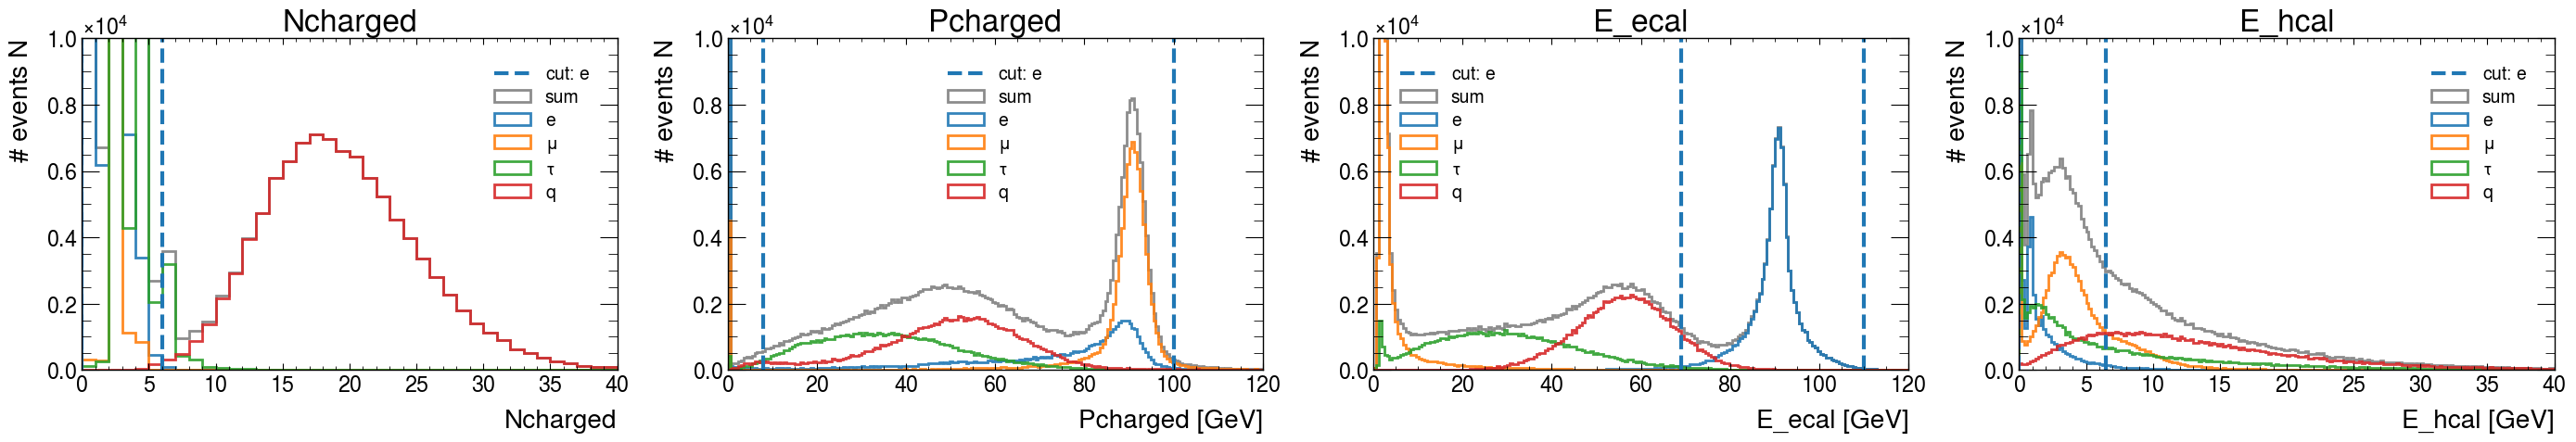

In [37]:
### Plotting only specific channels and cuts for all variables
spec_channels = ['tot', 'ee', 'mm', 'tt', 'qq']
spec_cuts = ['ee']

print(f'data from: {spec_channels}')
print(f'cuts from: {spec_cuts}')


### plotting
plt.style.use(mplhep.style.ATLAS)  # plot style of ATLAS
fig, axes = plt.subplots(1, 4, figsize=(28, 5))

# plot histograms for all variables and channels
for (i, variable) in zip(range(4), variables):
    for channel in spec_channels:
        axes[i].hist(array[channel][variable],
                     bins=bins_mc[variable],
                     histtype='step',
                     linewidth=2,
                     alpha= 0.9,
                     color=color[channel],
                     label=plot_label[channel])

    for cut in spec_cuts:
        axes[i].axvline(cuts[cut][variable][0], ls='--', lw=3, color=color[cut])
        axes[i].axvline(cuts[cut][variable][1], ls='--', lw=3, color=color[cut],
                        label=f'cut: {plot_label[cut]}')


    # plot settings
    axes[i].set_ylim(ylims_mc[variable])
    axes[i].set_title(variable)
    axes[i].set_xlabel(variable + unit[variable])
    axes[i].set_ylabel(r'# events $N$')
    axes[i].legend()


plt.tight_layout()
plt.show()

In the plots, specific cuts in combination with individual data can be observed.
- The parameter "spec_channels" specifies the data sets that will be plotted
- The parameter 'spec_cuts' specifies the specific particle types (ee, mm, tt or qq) for which the selection cuts will be shown

This piece of code can be used to play a bit around with the data sets and the cuts.

It can be observed, that:
- Ncharged is a good indicator to seperate the hadronic from the leptonic channels

- Pcharged is generally a good indicator to distinguish between mm and tt decays.
- The problem here is, that in many cases the momenta were not tracked correctly, resulting in a tracked value of Pcharged=0.
- The mm- respectively tt- Pcharged=0 events can not be distinguished.
- As there is no other effective criterion to prevent mm-events to be classified as tt-events, the selection rate here is the worst in our whole data.
- It is possible to prevent tt-events to be classified as mm-events via Ncharged. Unfortunately this is not possible the other way round.

- Eecal allows us to seperate ee and mm events very effectively

- Hcal can be used to avoid mistakenly assigning electrons to other events.

In [153]:
def identify(array_xx, channel):
    '''Returns a mask designed to identify events of channel in array_xx'''
    mask = True
    for variable in variables:
        # lower and upper cut
        mask *= array_xx[variable] >= cuts[channel][variable][0]
        mask *= array_xx[variable] <= cuts[channel][variable][1]
        # to include data with artifacts in 'Pcharged'
        # this does not ocurr for hadrons
        if variable=='Pcharged' and channel in ['ee', 'mm', 'tt']:
            mask += array_xx['Pcharged'] == 0
    return mask

In [236]:
# calculate efficiency matrix
filter_eff = np.zeros((4, 4))
filter_error = np.zeros((4, 4))
n_mc = np.zeros((4, 4))
N_mc = np.zeros(4)

for (j, col_ch) in zip(range(4), dist_channels):
    N_mc[j] = len(array[col_ch]['Pcharged'])  # 100000?
    for (i, row_ch) in zip(range(4), dist_channels):
        n_mc[i, j] = sum(identify(array[col_ch], row_ch))


filter_eff = n_mc / N_mc[None,:]
filter_error = np.sqrt((n_mc+1)*(n_mc+2)/(N_mc[None,:]+2)/(N_mc[None,:]+3) - (n_mc+1)**2/(N_mc[None,:]+2)**2)

In [222]:
print("efficiency matrix: \n", np.array_repr(filter_eff, precision=7, suppress_small=True), '\n \n',
      "errors of efficiency matrix: \n", np.array_repr(filter_error, precision=7, suppress_small=True))

efficiency matrix: 
 array([[0.88117, 0.     , 0.00794, 0.00022],
       [0.     , 0.89021, 0.00355, 0.     ],
       [0.01833, 0.07212, 0.74497, 0.00617],
       [0.     , 0.     , 0.00781, 0.90805]]) 
 
 errors of efficiency matrix: 
 array([[0.0010233, 0.00001  , 0.0002808, 0.000048 ],
       [0.00001  , 0.0009886, 0.0001883, 0.00001  ],
       [0.0004243, 0.0008181, 0.0013784, 0.0002478],
       [0.00001  , 0.00001  , 0.0002785, 0.0009138]])


### Matrix Inversion
To determine the uncertainties of the matrix elements after the inversion we diffierent methods and compare:
- analytical formula (see reference below)
- generate random efficiency matrices, invert all and determine the statistics via:
  * direct formula of mean and std
  * Gaussian fit to each matrix element

**References**:
* Propagation of Errors for Matrix Inversion: https://arxiv.org/abs/hep-ex/9909031v1

In [261]:
### invert matrix and propagate errors
inv_filter_eff = np.linalg.inv(filter_eff)
inv_filter_error = np.sqrt(np.linalg.multi_dot([inv_filter_eff**2,
                                                filter_error**2,
                                                inv_filter_eff**2]))

# covariance matrix of the matrix elements
inv_filter_cov = np.zeros((4, 4, 4, 4))

for i in range(4):
    for j in range(4):
        for k in range(4):
            for l in range(4):
                left_vec = (inv_filter_eff[i, :]*inv_filter_eff[k, :])
                right_vec = (inv_filter_eff[:, j]*inv_filter_eff[:, l])
                inv_filter_cov[i, j, k, l] = left_vec @ filter_error[:, :]**2 @ right_vec


print(inv_filter_cov[0, :, 3, :])

[[ 2.03532692e-10  3.75148772e-13 -4.49693302e-12 -5.36374370e-14]
 [ 3.75148772e-13  1.10014375e-10 -9.58795701e-12 -7.07924930e-14]
 [-4.49693302e-12 -9.58795701e-12  1.11921261e-10  9.17463388e-13]
 [-5.36374370e-14 -7.07924930e-14  9.17463388e-13 -1.59858573e-10]]


In [224]:
### Number of toy experiments to be done
ntoy = 1000

### Create numpy matrix of list to append elements of inverted toy matrices
inverse_toys = np.empty((4,4))

# Create toy efficiency matrix out of gaussian-distributed random values
for i in range(0,ntoy,1):
    toy_matrix = np.zeros((4,4))
    toy_matrix = np.random.normal(filter_eff,
                                  filter_error,
                                  size=(4,4))
    
    # Invert toy matrix
    inverse_toy = np.linalg.inv(toy_matrix)
    
    # Append values
    inverse_toys = np.dstack((inverse_toys,inverse_toy))

### calculate the statistics directly
inv_filter_eff_stat = np.mean(inverse_toys, axis=2)
inv_filter_error_stat = np.std(inverse_toys, axis=2)

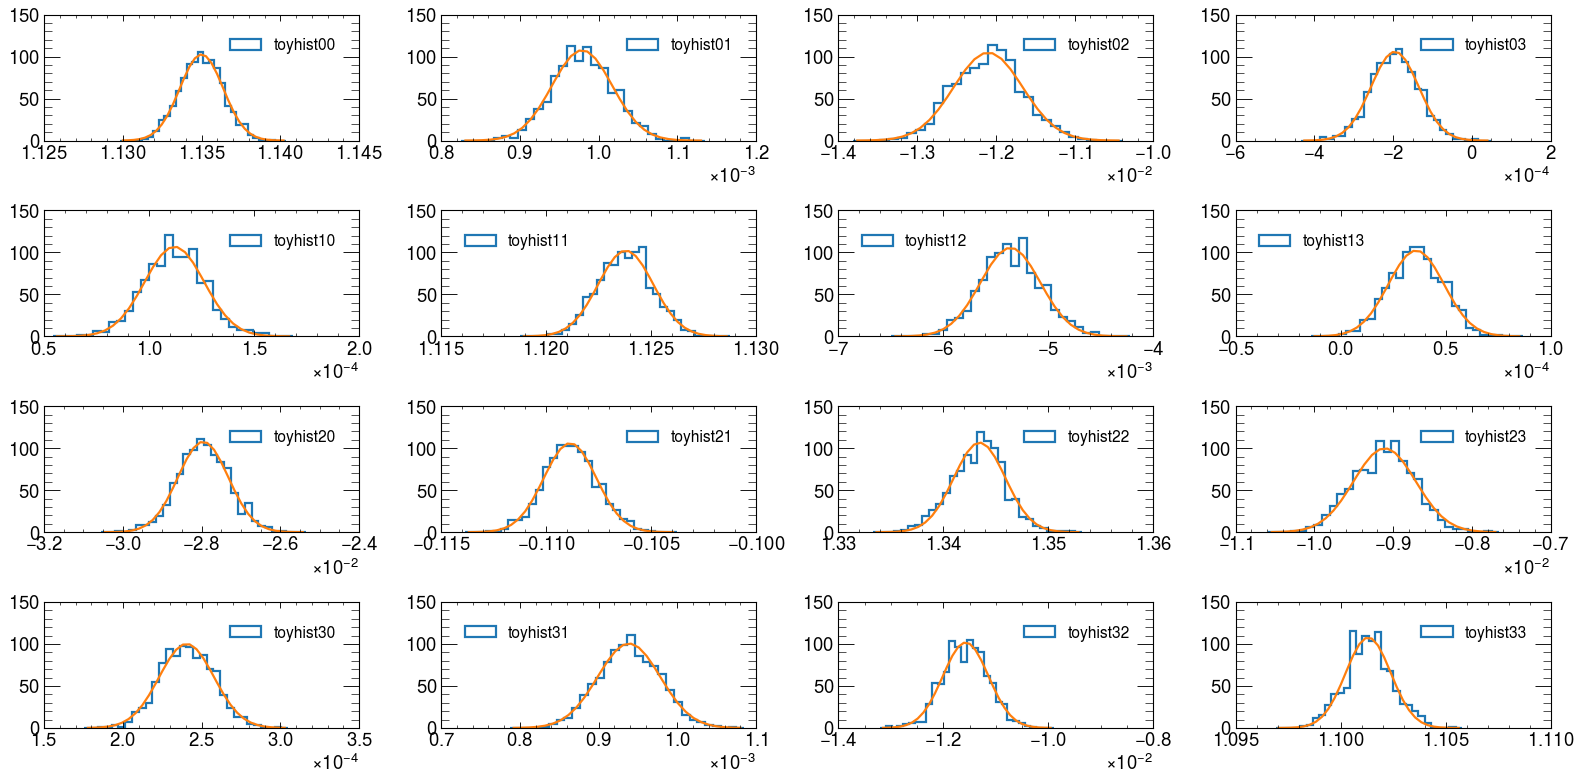

In [225]:
### Get statistics of toy experiments from Gaussian fit

from scipy.optimize import curve_fit


inv_filter_eff_fit = np.zeros((4,4))
inv_filter_error_fit = np.zeros((4,4))

# Define gaussian function to fit to the toy distributions:
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))


fig = plt.figure(figsize=(20, 10), dpi=80)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)
ax00 = plt.subplot(4,4,1)
ax01 = plt.subplot(4,4,2)
ax02 = plt.subplot(4,4,3)
ax03 = plt.subplot(4,4,4)

ax10 = plt.subplot(4,4,5)
ax11 = plt.subplot(4,4,6)
ax12 = plt.subplot(4,4,7)
ax13 = plt.subplot(4,4,8)

ax20 = plt.subplot(4,4,9)
ax21 = plt.subplot(4,4,10)
ax22 = plt.subplot(4,4,11)
ax23 = plt.subplot(4,4,12)

ax30 = plt.subplot(4,4,13)
ax31 = plt.subplot(4,4,14)
ax32 = plt.subplot(4,4,15)
ax33 = plt.subplot(4,4,16)

axes = [[ax00,ax01,ax02,ax03],
        [ax10,ax11,ax12,ax13],
        [ax20,ax21,ax22,ax23],
        [ax30,ax31,ax32,ax33]]

## Find suitable ranges to fit/plot gaussian distributions
ranges = np.zeros((4, 4, 2))
ranges[:, :, 0] =  inv_filter_eff - 4*inv_filter_error
ranges[:, :, 1] =  inv_filter_eff + 4*inv_filter_error

## Find suitable initial parameters for gaussian distributions
p0s = np.zeros((4, 4, 3))
p0s[:, :, 0] = 10000
p0s[:, :, 1] = inv_filter_eff
p0s[:, :, 2] = inv_filter_error


# Fill histograms for each inverted matrix coefficient:
for j in range(0, 4):
    for k in range(0, 4):

        # Diagonal and off-diagonal terms have different histogram ranges
        hbins, hedges, _ = axes[j][k].hist(inverse_toys[j,k,:],
                                           bins=30,
                                           range=ranges[j, k, :],
                                           histtype='step',
                                           linewidth=2,
                                           label=f'toyhist{j}{k}')
        axes[j][k].legend()


        # Get the fitted curve
        h_mid = 0.5*(hedges[1:] + hedges[:-1]) #Calculate midpoints for the fit
        coeffs, _ = curve_fit(gauss, h_mid, hbins, p0=p0s[j, k], maxfev=10000)
        h_fit = gauss(h_mid, *coeffs)

        inv_filter_eff_fit[j, k] = coeffs[1]
        inv_filter_error_fit[j, k] = coeffs[2]

        axes[j][k].plot(h_mid, h_fit,label=f'Fit{j}{k}')

plt.tight_layout()

In [226]:
### comparison
print("inverse matrix: \n", np.array_repr(inv_filter_eff, precision=7, suppress_small=True), '\n')
print("analytical errors: \n", np.array_repr(inv_filter_error, precision=7, suppress_small=True), '\n')
print("direct statistical errors: \n", np.array_repr(inv_filter_error_stat, precision=7, suppress_small=True), '\n')
print("fit errors: \n", np.array_repr(inv_filter_error_fit, precision=7, suppress_small=True))

inverse matrix: 
 array([[ 1.1351065,  0.0009803, -0.0121008, -0.0001928],
       [ 0.0001114,  1.1237644, -0.0053566,  0.0000364],
       [-0.0279421, -0.1088227,  1.3432479, -0.0091203],
       [ 0.0002403,  0.000936 , -0.0115531,  1.1013394]]) 

analytical errors: 
 array([[0.0013185, 0.0000387, 0.000429 , 0.0000601],
       [0.0000143, 0.0012487, 0.0002845, 0.0000126],
       [0.0006498, 0.001257 , 0.0024872, 0.0003671],
       [0.0000162, 0.0000372, 0.0004128, 0.0011084]]) 

direct statistical errors: 
 array([[0.0358531, 0.0000481, 0.0005814, 0.0000612],
       [0.0000148, 0.0354972, 0.0003392, 0.0000128],
       [0.0011039, 0.0036929, 0.0424804, 0.0004806],
       [0.000018 , 0.0000479, 0.0005681, 0.0347785]]) 

fit errors: 
 array([[0.0013777, 0.0000384, 0.0004377, 0.0000604],
       [0.0000142, 0.0013113, 0.0002855, 0.0000132],
       [0.0006398, 0.0012551, 0.0024553, 0.0003949],
       [0.0000174, 0.0000397, 0.000435 , 0.0010769]])


The analytical expression is exact as discussed in the reference. We see that the fit method closely matches these results. The other method however does not. Why is that so? We do not know. BUT: Since the analytical expression is exact, we do not have to find the reason. We stick with the exact propagation formula.

# Exercise 2: Separate $t$- and $s$-channel contributions

Only Feynman diagrams contributing to the production of $Z$ boson are to be considered for the measurements. The **electron** Monte Carlo sample incorporate contributions from $t$- and $s$-channels.
* Select/correct contributions producing $Z$ boson decays. (Hint: Which role does the $\cos(\theta)$ distribution play in separating $t$- and $s$-channels?)

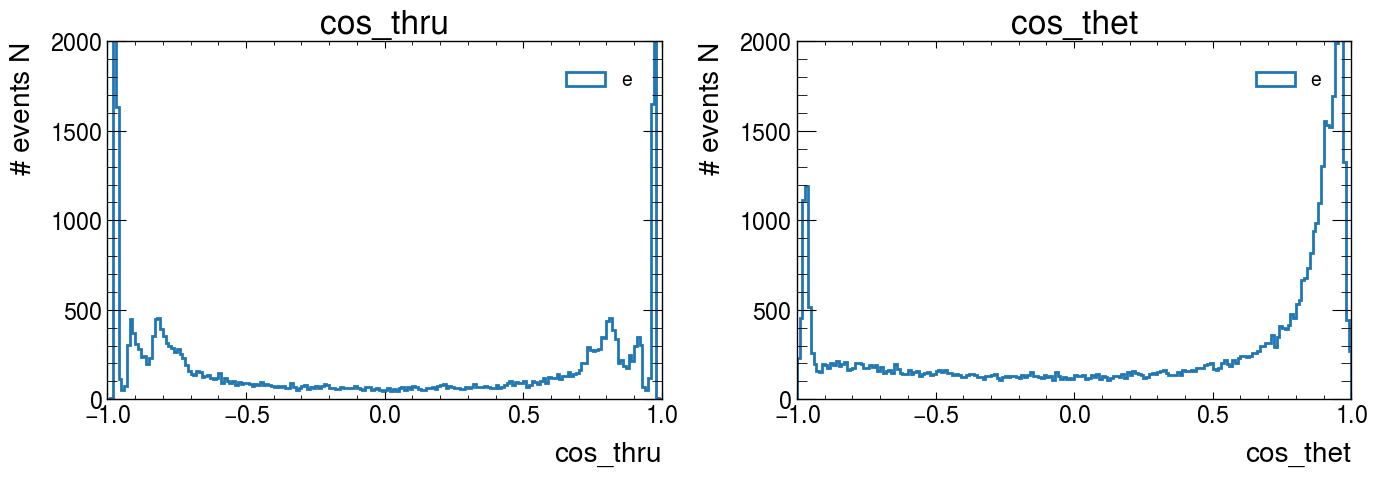

In [180]:
### We define set of angle variables
# add definitions to dictionaries from above
angle_variables = ['cos_thru', 'cos_thet']

# units corresponding to these variables
unit['cos_thru'] = ''
unit['cos_thet'] = ''

# bins for histograms
bins_mc['cos_thru'] = np.linspace(-1, 1, 201)
bins_mc['cos_thet'] = np.linspace(-1, 1, 201)

# limits for the plots
ylims_mc['cos_thru'] = (0, 2e3)
ylims_mc['cos_thet'] = (0, 2e3)


def s_distribution(cos_thet, A):
    return A*(1+cos_thet**2)

def t_distribution(cos_thet, A):
    return A*(1-cos_thet)**-2

### plotting
plt.style.use(mplhep.style.ATLAS)  # plot style of ATLAS
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# plot histograms for all variables and channels
for (i, variable) in zip(range(2), angle_variables):
    for channel in ['ee']:
        axes[i].hist(array[channel][variable],
                     bins=bins_mc[variable],
                     histtype='step',
                     linewidth=2,
                     color=color[channel],
                     label=plot_label[channel])
    # if i==1:
        # axes[i].plot(bins_mc['cos_thet'],s_distribution(bins_mc['cos_thet'], 100), label='s_channel')
        # axes[i].plot(bins_mc['cos_thet'],t_distribution(bins_mc['cos_thet'], 20), label='t_channel')
    
    # plot settings
    axes[i].set_ylim(ylims_mc[variable])
    axes[i].set_title(variable)
    axes[i].set_xlabel(variable + unit[variable])
    axes[i].set_ylabel(r'# events $N$')
    axes[i].legend()
    


plt.tight_layout()
plt.show()

# Way to go:
# Cite Paper: Precise Determination of the Z Resonance Parameters at LEP: "Zedometry"
# p.23 (ch. 7.2.1 t-channel contribution to ee -> ee)
# Some key points:
# - t-channel amplitude is non-resonant, dominated by photon exchange
# - relative size of t-channel amplitude depends on the scattering angle (theta)
# - cut is made at |cos(theta)| < 0.7
# - resulting from high-statistics Monte Carlo samples
# OPAL_Paper_3 results in the same

cuts['ee']['cos_thet'] = (-0.7, 0.7)

[111.18651851  12.58174787]
[[ 1.10416806 -0.04941872]
 [-0.04941872  0.01001559]]


<ipython-input-182-a6fa1fd9e526>:3: RuntimeWarning: divide by zero encountered in power
  return A*(1+cos_thet**2) + B*(1-cos_thet)**-2


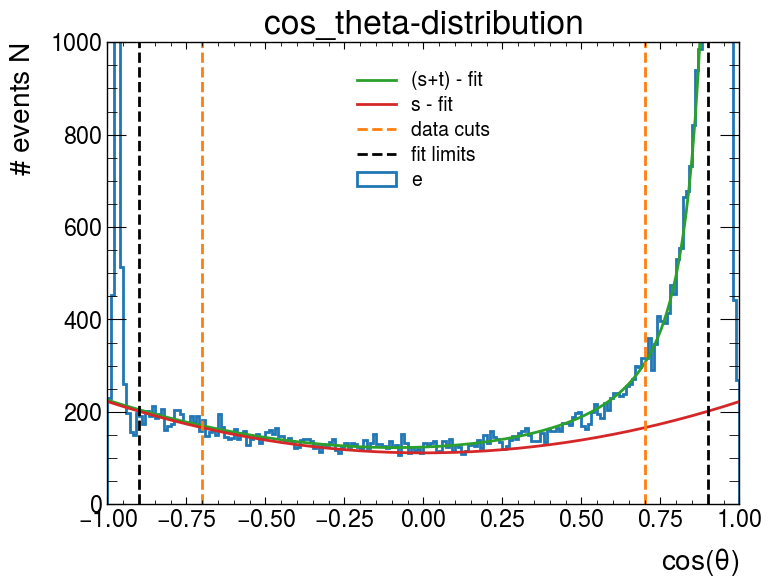

A_count = 21562.430316348728 +- 179.71764892266614 relative error: 0.008334758479724962
A_real = 29649.73826801215 +- relative error: 294.44481596184835 0.009930772855405352
Ratio real s-channel data / counted data = 1.375064769277496 +- 0.017827567491425708 relative error: 0.012964892919766168


In [182]:
# fit s- and t-channel distributions
def s_t_distribution(cos_thet, A, B):
    return A*(1+cos_thet**2) + B*(1-cos_thet)**-2

def s_t(A, B):
    return A * 1.62867 + B * 2.7451

# define variable and channel
variable = 'cos_thet'
channel = 'ee'

fig, ax = plt.subplots()
hbins, hedges, _ = ax.hist(array[channel][variable], bins=np.linspace(-1,1,201),
                        histtype='step', linewidth=2, color='C0',
                        label=plot_label[channel])

h_mid = 0.5*(hedges[1:] + hedges[:-1]) #Calculate midpoints for the fit
coeffs, errors = curve_fit(s_t_distribution, h_mid[10:-10], hbins[10:-10], maxfev=10000)  # fit in between -0.9 and 0.9
print(coeffs)
print(errors)
ax.plot(bins_mc[variable], s_t_distribution(bins_mc[variable], coeffs[0], coeffs[1]), color="C2", label='(s+t) - fit')
ax.plot(bins_mc[variable], s_distribution(bins_mc[variable], coeffs[0]), color="C3", label='s - fit')
ax.axvline(cuts[channel][variable][1], ls='--', color = 'C1', label=r'data cuts')
ax.axvline(cuts[channel][variable][0], ls='--', color = 'C1')
ax.axvline(-0.9, ls='--', color = 'black', label=r'fit limits')
ax.axvline(0.9, ls='--', color = 'black')
ax.set_ylim(0,1e3)
ax.set_title(r'cos_theta-distribution')
ax.set_xlabel(r'cos($\theta$)')
ax.set_ylabel(r'# events $N$')
ax.legend()
plt.show()

# print(h_mid)
# print(hbins)

bin_width = hedges[1]-hedges[0]

A_count = s_t(coeffs[0], coeffs[1]) / bin_width
u_A_count = np.sqrt((s_t(errors[0,0], 0))**2
                      + s_t(0, errors[1,1])**2
                      + 2 * s_t(errors[0,0],0) * 
                      s_t(0, errors[1,1])*errors[0,1]) / bin_width
A_real = 8/3 * coeffs[0] / bin_width
u_A_real = 8/3 * errors[0,0] / bin_width
ratio_s_t = A_real / A_count
u_ratio_s_t = np.sqrt((u_A_real/A_count)**2 + (A_real/A_count**2 * u_A_count)**2)
print('A_count =', A_count, '+-', u_A_count, 'relative error:', u_A_count/A_count)
print('A_real =', A_real, '+-', 'relative error:', u_A_real, u_A_real/A_real)
print('Ratio real s-channel data / counted data =', ratio_s_t, '+-', u_ratio_s_t, 'relative error:', u_ratio_s_t/ratio_s_t)

In [170]:
def identify_s(array_ee):
    '''Returns a mask designed to identify s-channel in array_ee'''
    mask = True
    mask *= array_ee['cos_thet'] >= cuts['ee']['cos_thet'][0]
    mask *= array_ee['cos_thet'] <= cuts['ee']['cos_thet'][1]
    return mask

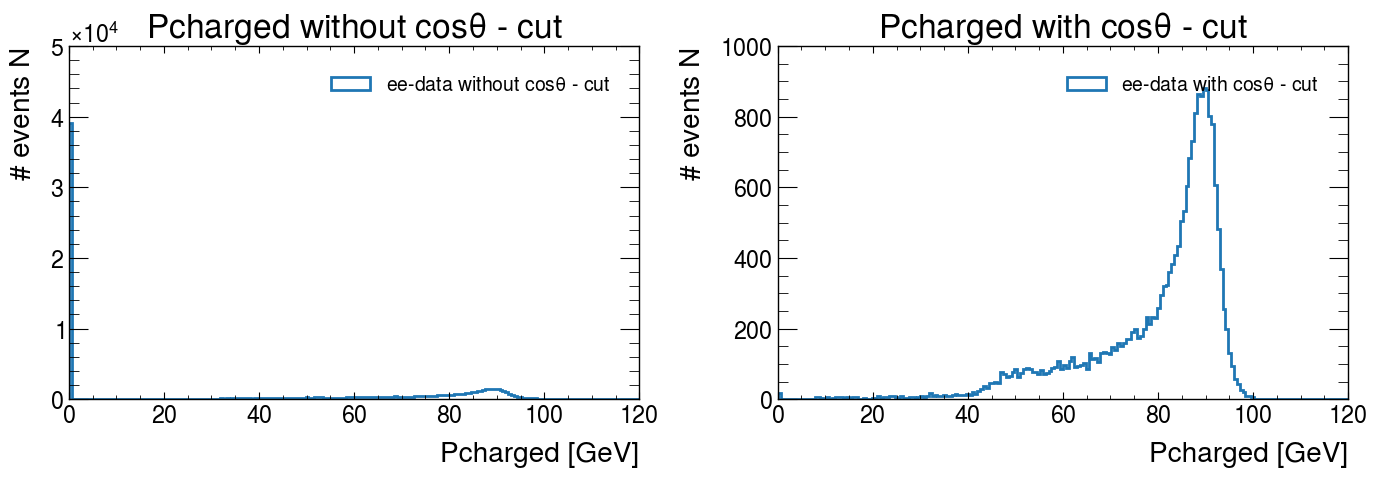

In [183]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

variable = 'Pcharged'
mask_ee = identify(array['tot'],'ee')
mask_thet_ee = mask_ee * identify_s(array['tot'])

axes[0].hist(array['tot'][variable][mask_ee], bins=np.linspace(0,120,201), histtype='step',linewidth=2,label=r'ee-data without cos$\theta$ - cut')
axes[1].hist(array['tot'][variable][mask_thet_ee], bins=np.linspace(0,120,201), histtype='step',linewidth=2,label=r'ee-data with cos$\theta$ - cut')
axes[0].set_title(r"Pcharged without cos$\theta$ - cut")
axes[1].set_title(r"Pcharged with cos$\theta$ - cut")
axes[0].set_xlabel(variable + unit[variable])
axes[1].set_xlabel(variable + unit[variable])
axes[0].set_ylabel(r'# events $N$')
axes[1].set_ylabel(r'# events $N$')
axes[0].legend()
axes[1].legend()

plt.tight_layout()
plt.show()

# Exercise 3: Measurement of the total production cross sections

For **each** of the seven centre-of-mass energies:
* Determine the number of events in the handronic channel *and* in the three leptonic channels
* Substract the background and correct for selection efficiencies accordingly
* Then, calculate the differnetial cross sections for the hadronic *and* the leptnic channels
* Add the radiation corrections from The table given below. **Don't forget to take the uncertainties (errors) into account!**

| $\sqrt{s}$   \[GeV\]| Correction hadronic channel    \[nb\] |  Correction leptonic channel   \[nb\]|
| --- | --- | --- |
| 88.47 | +2.0  | +0.09 |
| 89.46 | +4.3  | +0.20 |
| 90.22 | +7.7  | +0.36 |
| 91.22 | +10.8 | +0.52 |
| 91.97 | +4.7  | +0.22 |
| 92.96 | -0.2  | -0.01 |
| 93.76 | -1.6  | -0.08 |

Feel free to access these values using the dictionary 'xs_corrections' given below.
* Once the total cross section for all four decay channels at all seven energies have been measured, fit a **Breit-Wigner distribution** to measure the $Z$ boson mass ($m_Z$) and the resonance width ($\Gamma_Z$) and the peak cross section s of the resonance for the hadronic and the leptonic channels. Again, **propagate the uncertainties carefully**.
* Compare your results to the OPAL cross section s and the theoretical predictions. How many degrees of freedom does the fit have? How can you udge if the model is compatible with the measured data? Calculate the  **confidence levels**.
* Calculate the partial widths for all channels from the measured cross sections on the peak. Which is the best partial width to start with? Compare them with the theoretical predictions and the values that you have calculated in the beginning.
* Determine from your results the **number of generations of light neutrinos**. Which assumptions are necessary?
* Discuss in detail the systematic uncertainties in the whole procedure of the analysis. Which assumptions were necessary?

These are some **references** that might be interesting to look up:
* Particle Data Book: https://pdg.lbl.gov/2020/download/Prog.Theor.Exp.Phys.2020.083C01.pdf
** Resonances: https://pdg.lbl.gov/2017/reviews/rpp2017-rev-resonances.pdf
* Precision Electroweak Measurements on the Z Resonance (Combination LEP): https://arxiv.org/abs/hep-ex/0509008
* Measurement of the $Z^0$ mass and width with the OPAL detector at LEP: https://doi.org/10.1016/0370-2693(89)90705-3
* Measurement of the $Z^0$ line shape parameters and the electroweak couplings of charged leptons: https://inspirehep.net/literature/315269
* The OPAL Collaboration, *Precise Determination of the $Z$ Resonance Parameters at LEP: "Zedometry"*: https://arxiv.org/abs/hep-ex/0012018
* Fitting a Breit-Wigner curve using uproot: https://masonproffitt.github.io/uproot-tutorial/07-fitting/index.html

In [1]:
xs_corrections = { 'energy' : [88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                   'hadronic' : [2.0, 4.3, 7.7, 10.8, 4.7, -0.2, -1.6],
                   'leptonic' : [0.09, 0.20, 0.36, 0.52, 0.22, -0.01, -0.08]}

In [94]:
# Data management

path_data = 'opal_data/data'

# Open the files
file_lep = uproot.open(path_data+'/daten_1.root')

# Name the ttree name
ttree_name = 'myTTree'

# Load branches
branches_lep = file_lep[ttree_name].arrays()

# convert data into dictionaries of numpy arrays
array_lep = {}

for variable in variable_names:
    array_lep[variable] = ak.to_numpy(branches_lep[variable])

N = len(array_lep['E_ecal'])
# only 176 000 data
print('Number of events:', N)

print('These are the different variables: ', file_lep[ttree_name].keys(), ' the same as before')
# print('E_lep = {0:4.2f} GeV = const.'.format(branches_ee['E_lep'][0]))

Number of events: 175883
These are the different variables:  ['run', 'event', 'Ncharged', 'Pcharged', 'E_ecal', 'E_hcal', 'E_lep', 'cos_thru', 'cos_thet']  the same as before


In [147]:
# identify the events of each energy

# dictionary for different beam energies
array_E_lep = {}
E_lep = np.zeros(7)

# roughly estimated bin edges
E_bin_edges = [44, 44.5, 44.9, 45.3, 45.8, 46.2, 46.7, 47.5]

for i in range(7):
    array_E_lep[i] = {}  # sub dictionary for different variables
    mask = True
    mask *= (array_lep['E_lep'] >= E_bin_edges[i])
    mask *= (array_lep['E_lep'] <= E_bin_edges[i+1])

    # mask arrays of all variables
    for variable in variable_names:
        array_E_lep[i][variable] = array_lep[variable][mask]

    E_lep[i] = np.mean(array_E_lep[i]['E_lep'])

In [189]:
# M_all_chs contains vectors of event numbers (of all channels)
M_all_chs = np.zeros((7, 4))

for i in range(7):
    for (j, ch) in zip(range(4), dist_channels):
        M_all_chs[i, j] = np.sum(identify(array_E_lep[i], ch))


print('E_lep | [ee,     mm,    tt,    qq]')
print('------------------------------------')
for i in range(7):
    print(round(E_lep[i], 2), '|', M_all_chs[i, :])

E_lep | [ee,     mm,    tt,    qq]
------------------------------------
44.24 | [1921.  133.  416. 3287.]
44.74 | [1664.  253.  442. 4948.]
45.11 | [1325.  344.  406. 6908.]
45.62 | [10849.  3992.  5256. 85110.]
45.99 | [ 1747.   680.   855. 13707.]
46.49 | [1077.  284.  455. 6020.]
46.86 | [1609.  331.  482. 6621.]


In [188]:
# M are vectors of event numbers (only s channel)
M = M_all_chs
u_M = np.sqrt(M_all_chs)

# for ee we have to separate s and t channel
# keep only s channel and correct for missing events
for i in range(7):
    mask_ee_s = identify(array_E_lep[i], 'ee')
    mask_ee_s *= identify_s(array_E_lep[i])
    M[i, 0] = np.sum(mask_ee_s)
    M[i, 0] *= ratio_s_t  # correct for s-channel selection
    u_M[i, 0] = M[i, 0] * np.sqrt((u_ratio_s_t/ratio_s_t)**2 + 1/M[i, 0])  # error propagation
    
    
print('E_lep | [ee,     mm,    tt,    qq]')
print('------------------------------------')
for i in range(7):
    print(round(E_lep[i], 2), '|', np.round(M[i, :], 0), np.round(u_M[i, :], 0), np.round(u_M[i, :]/M[i, :], 3))

E_lep | [ee,     mm,    tt,    qq]
------------------------------------
44.24 | [ 282.  133.  416. 3287.] [17. 12. 20. 57.] [0.061 0.087 0.049 0.017]
44.74 | [ 359.  253.  442. 4948.] [20. 16. 21. 70.] [0.054 0.063 0.048 0.014]
45.11 | [ 364.  344.  406. 6908.] [20. 19. 20. 83.] [0.054 0.054 0.05  0.012]
45.62 | [ 3572.  3992.  5256. 85110.] [ 76.  63.  72. 292.] [0.021 0.016 0.014 0.003]
45.99 | [  499.   680.   855. 13707.] [ 23.  26.  29. 117.] [0.047 0.038 0.034 0.009]
46.49 | [ 226.  284.  455. 6020.] [15. 17. 21. 78.] [0.068 0.059 0.047 0.013]
46.86 | [ 286.  331.  482. 6621.] [17. 18. 22. 81.] [0.061 0.055 0.046 0.012]


In [285]:
# N are vectors of event numbers corrected for efficiency
N = np.zeros((7, 4))
N_cov = np.zeros((7, 4, 4))
u_N = np.zeros((7, 4))

for i in range(7):
    N[i, :] = inv_filter_eff @ M[i, :]
    for j in range(4):
        for k in range(4):
            N_cov[i, j, k] = M[i, :] @ inv_filter_cov[j, :, k, :] @ M[i, :]
            N_cov[i, j, k] += (inv_filter_eff[j, :] * inv_filter_eff[k, :]) @ u_M[i, :]**2
    u_N[i, :] = np.sqrt(np.diagonal(N_cov[i, :, :]))


print('E_lep | [ee,     mm,    tt,    qq]')
print('------------------------------------')
for i in range(7):
    print(round(E_lep[i], 2), '|', np.round(N[i, :], 0), np.round(u_N[i, :], 0), np.round(u_N[i, :]/N[i, :], 3))

E_lep | [ee,     mm,    tt,    qq]
------------------------------------
44.24 | [ 295.  139.  401. 3564.] [18. 12. 22. 62.] [0.062 0.088 0.054 0.017]
44.74 | [ 376.  266.  405. 5366.] [21. 17. 22. 77.] [0.055 0.063 0.056 0.014]
45.11 | [ 382.  363.  344. 7495.] [21. 20. 22. 90.] [0.055 0.054 0.063 0.012]
45.62 | [ 3732.  4211.  4555. 92333.] [ 81.  67.  81. 328.] [0.022 0.016 0.018 0.004]
45.99 | [  520.   717.   741. 14870.] [ 25.  28.  31. 128.] [0.048 0.039 0.042 0.009]
46.49 | [ 234.  299.  411. 6530.] [16. 18. 23. 84.] [0.07  0.06  0.056 0.013]
46.86 | [ 298.  349.  430. 7182.] [18. 19. 24. 89.] [0.062 0.055 0.055 0.012]


In [293]:
%pip install pandas

import pandas as pd

lumi_df = pd.read_csv('opal_data/lumi-files/daten_1.csv','r')

print(lumi_df.keys())

#lumi_df['']

Defaulting to user installation because normal site-packages is not writeable


     |█▋                              | 481 kB 9.9 MB/s eta 0:00:01

     |██████▊                         | 2.0 MB 9.9 MB/s eta 0:00:01

     |███████████▉                    | 3.6 MB 9.9 MB/s eta 0:00:01

     |████████████████████▌           | 6.2 MB 9.9 MB/s eta 0:00:01

     |█████████████████████████████▍  | 8.9 MB 9.9 MB/s eta 0:00:01

     |████████████████████████████████| 9.7 MB 9.9 MB/s eta 0:00:01

     |████████████████████████████████| 9.7 MB 9.9 MB/s 


You should consider upgrading via the '/usr/local/sage/local/bin/python3 -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


FileNotFoundError: [Errno 2] No such file or directory: 'opal_data/lumi-files/daten_1.csv'

# Exercise 4: Forward-backward asymmetry and $\sin^2(\theta_\text{W})$ in muon final states

* Using the **muon channel only**, measure the forward-backward asymmetry $\mathcal{A}_\text{FB}$ using OPAL data and muon Monte Carlo events. Take into account the radiation corrections given below. 

| $\sqrt{s}$   \[GeV\]| Radiation correction [-]|  
| --- | --- | 
| 88.47 | 0.021512  | 
| 89.46 | 0.019262  | 
| 90.22 | 0.016713  | 
| 91.22 | 0.018293  | 
| 91.97 | 0.030286  | 
| 92.96 | 0.062196  | 
| 93.76 | 0.093850  | 

Feel free to use the dictionary 'radiation_corrections' given below.

* Measure the **Weinberg angle** as $\sin^2(\theta_\text{W})$. Compare the measurement with the literature.

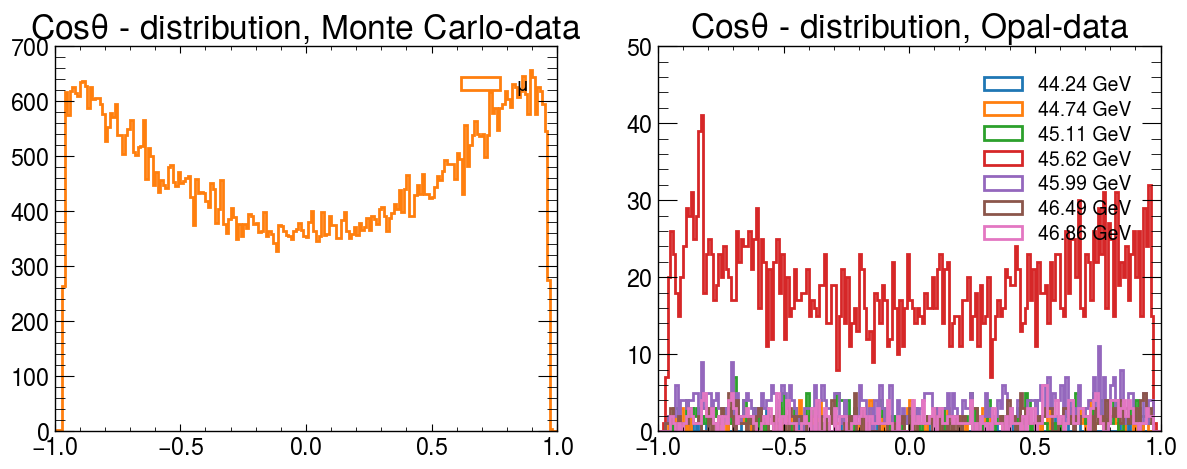

In [263]:
# Calculate the Weinberg angle using the Monte Carlo events
array_E_lep_mm = {}

for i in range(7):
    array_E_lep_mm[i] = {}  # sub dictionary for different variables
    mask = identify(array_E_lep[i],'mm')

    # mask arrays of all variables
    for variable in variable_names:
        array_E_lep_mm[i][variable] = array_E_lep[i][variable][mask]

variable = 'cos_thet'
channel = 'mm'

bins_mc[variable] = np.linspace(-1,1, 201)

fig, ax = plt.subplots(1,2, figsize=(14, 5))
ax[0].hist(array_mm[variable], bins=bins_mc[variable], histtype='step', linewidth=2, color=color[channel], label=plot_label[channel])
for j in range(7):
    ax[1].hist(array_E_lep_mm[j][variable], bins=bins_mc[variable], histtype='step',
               linewidth=2, label=str(E_lep[j].round(2)) + ' GeV')
ax[0].set_title(r'Cos$\theta$ - distribution, Monte Carlo-data')
ax[1].set_title(r'Cos$\theta$ - distribution, Opal-data')
ax[0].legend()
ax[1].legend()
plt.show()

In [292]:
# Function to determine weinberg-angle
def sin2_w(A):
    return (1-np.sqrt(A/3)) * 1/4
print(sin2_w(2))
print(1/12*(3-np.sqrt(6)))

# Data managment for forward backward asymmetry
A_fb = {}
W_angle = {}

# Analyse the monte-carlo Data
print(r'Elep_mc =', array['mm']['E_lep'][0], 'GeV')  # Elep=45.624 GeV for Monte Carlo-data

# forward term
A_f = np.sum((array_mm['cos_thet']>0) * (array_mm['cos_thet']<1))
# backwards term
A_b = np.sum((array_mm['cos_thet']>-1) * (array_mm['cos_thet']<0))
N = (A_f+A_b)

a_fb = (A_f-A_b) / N  # calculate Asymmetry
u_a_fb = np.sqrt((np.sqrt(A_f)/N)**2 + (np.sqrt(A_b)/N)**2 + (np.sqrt(N)/N**2)**2)

w_angle = sin2_w(a_fb)  # calculate Weinberg-angle
u_w_angle = 1/(8*np.sqrt(3)) * 1/np.sqrt(a_fb) * u_a_fb

A_fb['mc'] = (a_fb, u_a_fb)
W_angle['mc'] = (w_angle, u_w_angle)

A_fb['opal'] = {}  # create subdictionary
W_angle['opal'] = {}  # create subdict

for i in range(7):
    # print('E_lep=', E_lep[i])
    A_f = np.sum((array_E_lep_mm[i]['cos_thet']>0) * (array_E_lep_mm[i]['cos_thet'])<1)
    A_b = np.sum((array_E_lep_mm[i]['cos_thet']>-1) * (array_E_lep_mm[i]['cos_thet'])<0)
    N = (A_f+A_b)

    a_fb = (A_f-A_b) / N
    u_a_fb = np.sqrt((np.sqrt(A_f)/N)**2 + (np.sqrt(A_b)/N)**2 + (np.sqrt(N)/N**2)**2)

    w_angle = sin2_w(a_fb)
    u_w_angle = 1/(8*np.sqrt(3)) * 1/np.sqrt(a_fb) * u_a_fb

    A_fb['opal'][i] = (a_fb, u_a_fb)
    W_angle['opal'][i] = (w_angle, u_w_angle)
    
print(A_fb)
print(W_angle)

0.04587585476806849
0.045875854768068505
Elep_mc = 45.624 GeV
{'mc': (0.004508867439297285, 0.003336615953977342), 'opal': {0: (0.263681592039801, 0.0705354345113459), 1: (0.3333333333333333, 0.05360584806206117), 2: (0.27920792079207923, 0.04449950319411626), 3: (0.3301144492131617, 0.013372617592820367), 4: (0.3416666666666667, 0.03227487872862326), 5: (0.4191780821917808, 0.05234258870223412), 6: (0.38461538461538464, 0.04688083631849991)}}
{'mc': (0.24030800648376746, 0.0035860956911550313), 'opal': {0: (0.1758827516644797, 0.009913267505116813), 1: (0.16666666666666669, 0.006700731007757648), 2: (0.17373184358352223, 0.006077719894973501), 3: (0.16707000326415333, 0.001679707047003902), 4: (0.16563143028618088, 0.003984856618567185), 5: (0.1565501379758709, 0.005834522247243379), 6: (0.16048564074507088, 0.0054554604317014485)}}


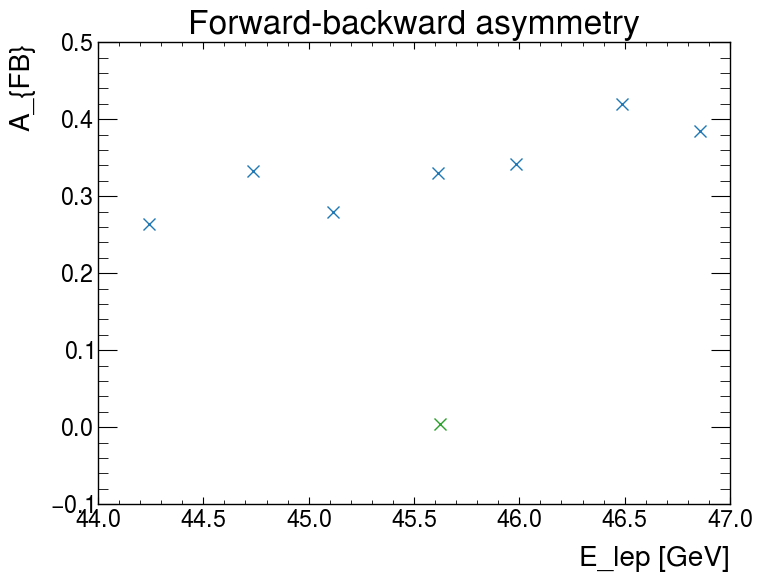

[88.4805069  89.47298431 90.22796631 91.23229218 91.97161102 92.9706192
 93.71835327]


In [288]:
fig, ax = plt.subplots()
# plot monte carlo data point
ax.plot(array['mm']['E_lep'][0], A_fb['mc'][0], marker = 'x', color ='C2')
# plot opal data
for i in range(7):
    ax.plot(E_lep[i], A_fb['opal'][i][0], marker = 'x', lw=0, color ='C0')
ax.set_xlabel(r'E_lep [GeV]')
ax.set_ylabel(r'A_{FB}')
ax.set_title(r'Forward-backward asymmetry')
plt.show()
print(E_lep*2)

In [2]:
radiation_corrections = { 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                          'correction' : [0.021512, 0.019262, 0.016713, 0.018293, 0.030286, 0.062196, 0.093850]}

# Exercise 5: Tests on lepton universality¶

* Test the lepton universality from the total cross sectinos on the peak for $Z\to e^+ e^-$, $Z\to \mu^+ \mu^-$ and $Z\to \tau^+ \tau^-$ events. What is the ratio of the total cross section of the hadronic channel to the leptonic channels on the peak? Compare with the ratios obtained from the branching rations and discuss possible differences.